# Project: Support Vector Machine (SVM) Classification for Player-Centric Chess Outcome Prediction

## Overview and Goals

This project utilizes a Support Vector Machine (SVM) classifier to predict the outcome (Win, Loss, Draw) of chess games for a specific player. Since dynamic engine analysis (Stockfish Evaluation) is unavailable, the model focuses on **historical and statistical context** to determine predictive factors.

**Key Features Engineered:**
1.  **Opening Performance:** Historical Win Rate (WR) for the specific opening (ECO code).
2.  **Rivalry Metric:** Historical WR against the specific opponent.
3.  **ELO Differential:** The raw rating difference between the player and opponent.
4.  **Game Length & Color.**

**Advanced SVM Topics Covered:**
*   Kernel Comparison (Linear vs. RBF)
*   Hyperparameter Tuning using Grid Search (`C` and `gamma`)
*   Handling Class Imbalance (`class_weight='balanced'`)
*   Visualization of Decision Boundaries and the Kernel Trick.

In [1]:
# ===========================================================
# 1. Load and Parse All PGN Files
# ===========================================================

import os
import pandas as pd
import chess.pgn

# --- Configuration ---
PLAYER_NAMES = ['LucienEvans', 'nit4_S'] # The user accounts we are analyzing
PGN_FILES = [
    r'E:\Puducherry Technological University\MLS\SVM DEMO\lichess_games.pgn',
    r'E:\Puducherry Technological University\MLS\SVM DEMO\db\nit4_S_chesscom.pgn',
    r'E:\Puducherry Technological University\MLS\SVM DEMO\db\nit4_S_lichess.pgn'
]

# --- Load Multiple PGNs ---
all_games = []

for pgn_path in PGN_FILES:
    if not os.path.exists(pgn_path):
        print(f"⚠️ WARNING: PGN file not found, skipping: {pgn_path}")
        continue

    with open(pgn_path, encoding="utf-8") as pgn_file:
        while True:
            game = chess.pgn.read_game(pgn_file)
            if game is None:
                break

            white = game.headers.get("White")
            black = game.headers.get("Black")

            # Find which of our players is in the game
            matched_player = next((p for p in PLAYER_NAMES if p in [white, black]), None)
            if not matched_player:
                continue

            result = game.headers.get("Result")
            if result not in ["1-0", "0-1", "1/2-1/2"]:
                continue

            is_white = (white == matched_player)

            try:
                player_elo = int(game.headers.get("WhiteElo") if is_white else game.headers.get("BlackElo"))
                opponent_elo = int(game.headers.get("BlackElo") if is_white else game.headers.get("WhiteElo"))
            except (TypeError, ValueError):
                continue

            # Determine Outcome
            if result == "1/2-1/2":
                outcome, score = "Draw", 0.5
            elif (is_white and result == "1-0") or (not is_white and result == "0-1"):
                outcome, score = "Win", 1.0
            else:
                outcome, score = "Loss", 0.0

            all_games.append({
                "Player_Name": matched_player,
                "Outcome": outcome,
                "Score": score,
                "Color": "White" if is_white else "Black",
                "Opening_ECO": game.headers.get("ECO", "UNK"),
                "Opponent_Name": black if is_white else white,
                "ELO_Diff": player_elo - opponent_elo,
                "Opponent_Rating": opponent_elo,
                "Moves": len(list(game.mainline_moves())),
            })

# --- Create DataFrame ---
df_raw = pd.DataFrame(all_games)
if df_raw.empty:
    raise ValueError("No valid games found in the PGN files.")

print(f"✅ Successfully loaded a total of {len(df_raw)} games for players: {PLAYER_NAMES}")
df_raw.head()

illegal san: 'dxc4' in 8/p1p1Bp1p/2p2P2/7k/6R1/5R2/PrP3KP/8 w - - 2 39 while parsing <Game at 0x28f7867c460 ('nit4_S' vs. 'Mirta1968', '2022.12.31' at 'Chess.com')>
illegal san: 'd3' in 3K3r/8/3k4/8/8/8/8/8 w - - 26 68 while parsing <Game at 0x28f7856a5e0 ('nit4_S' vs. 'Chaves1967', '2023.01.25' at 'Chess.com')>
illegal san: '3b1' in 5Q2/ppp3r1/2n3R1/3kP3/7p/PP2n2P/3P4/4R2K b - - 0 42 while parsing <Game at 0x28f785c57c0 ('elmarpatricio' vs. 'nit4_S', '2023.02.28' at 'Chess.com')>
illegal san: '1b2r' in 8/pp3k2/2pp4/4p1R1/4P2B/2Pq3P/1P3PK1/8 w - - 4 43 while parsing <Game at 0x28f789825e0 ('dragonbankrs' vs. 'nit4_S', '2023.03.31' at 'Chess.com')>
illegal san: 'd5' in 3r4/p5k1/2r1Bp2/4p3/7N/2p3P1/P6P/2R4K w - - 5 39 while parsing <Game at 0x28f787190d0 ('nit4_S' vs. 'Lexnytate', '2023.05.01' at 'Chess.com')>
illegal san: 'O-O' in 8/R7/2p1b3/1p6/5k2/4pp2/PP3K2/8 w - - 0 40 while parsing <Game at 0x28f78936760 ('Black_Horse_Chess' vs. 'nit4_S', '2023.05.31' at 'Chess.com')>
illegal san: 

✅ Successfully loaded a total of 6966 games for players: ['LucienEvans', 'nit4_S']


,Player_Name,Outcome,Score,Color,Opening_ECO,Opponent_Name,ELO_Diff,Opponent_Rating,Moves
0,LucienEvans,Win,1.0,Black,A00,TakiliSiak,12,2226,68
1,LucienEvans,Loss,0.0,White,A00,mr_coach,-7,2251,86
2,LucienEvans,Loss,0.0,White,A00,Pilot100,-171,2418,124
3,LucienEvans,Win,1.0,Black,A01,tapcblade777,13,2228,60
4,LucienEvans,Win,1.0,White,A00,KingSolomonIsBack,83,2154,49


## 2. Player Performance Dashboard

Before building the model, let's analyze the historical performance from the loaded games.

--- Overall Performance ---


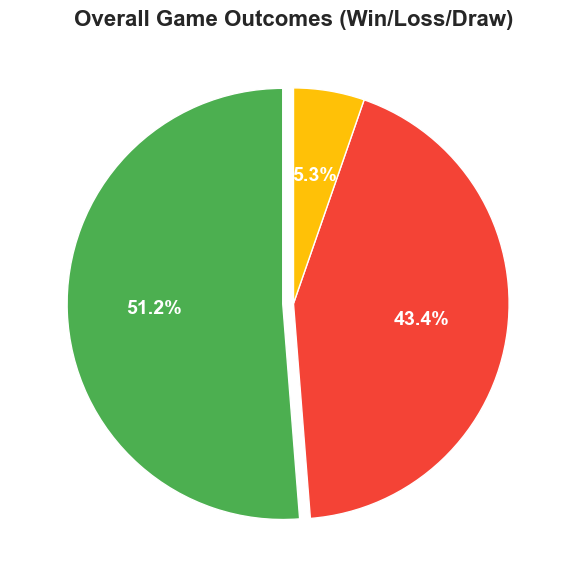


--- Top 10 Most-Faced Rivals ---


,Games_Played,Win_Rate
Opponent_Name,,
tincho_akd91,22,79.55%
byrondupies2,10,80.00%
MehmetAkifHarputlu,9,61.11%
pooyajses,9,88.89%
chessyriy,8,100.00%
accz62,8,100.00%
Abhi2k14,7,64.29%
Ver1te,7,78.57%
BigM2003,7,71.43%



--- Top 10 Most-Used Openings (by ECO code) ---


,Times_Played,Win_Rate
Opening_ECO,,
A00,1482,56.24%
B06,763,50.39%
A40,444,48.99%
A07,430,55.12%
A04,282,56.56%
A02,204,51.96%
C50,199,62.81%
A03,168,50.60%
A08,168,58.93%


In [15]:
# ===========================================================
# 2. Player Performance Dashboard
# ===========================================================
import matplotlib.pyplot as plt
import seaborn as sns

# Set a professional plot style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 7)

# --- Overall Win/Loss/Draw Ratio ---
print("--- Overall Performance ---")
outcome_counts = df_raw['Outcome'].value_counts()
outcome_counts.plot(
    kind='pie',
    autopct='%1.1f%%',
    colors=['#4CAF50', '#F44336', '#FFC107'], # Green for Win, Red for Loss, Amber for Draw
    explode=(0.05, 0, 0),
    startangle=90,
    textprops={'fontsize': 14, 'color': 'white', 'weight': 'bold'}
)
plt.title('Overall Game Outcomes (Win/Loss/Draw)', fontsize=16, weight='bold')
plt.ylabel('') # Hide the 'Outcome' label on the side
plt.show()


# --- Most Faced Rivals ---
print("\n--- Top 10 Most-Faced Rivals ---")
rival_summary = df_raw.groupby('Opponent_Name').agg(
    Games_Played=('Outcome', 'count'),
    Win_Rate=('Score', 'mean')
).sort_values(by='Games_Played', ascending=False).head(10)

# Display styled DataFrame
display(rival_summary.style.format({'Win_Rate': "{:.2%}"})
        .background_gradient(cmap='coolwarm', subset=['Win_Rate'])
        .set_caption("Performance Against Frequent Opponents"))


# --- Most Used Openings ---
print("\n--- Top 10 Most-Used Openings (by ECO code) ---")
opening_summary = df_raw.groupby('Opening_ECO').agg(
    Times_Played=('Outcome', 'count'),
    Win_Rate=('Score', 'mean')
).sort_values(by='Times_Played', ascending=False).head(10)

# Display styled DataFrame
display(opening_summary.style.format({'Win_Rate': "{:.2%}"})
         .background_gradient(cmap='viridis', subset=['Times_Played'])
         .set_caption("Performance in Frequent Openings"))

## 3. Data Splitting & Leak-Proof Feature Engineering

**Crucial Step:** We split the data into training and testing sets *before* creating statistical features like `Opening_WR` and `Rival_WR`.

This prevents **data leakage**, ensuring that information from the test set (e.g., the outcome of a future game) does not influence the features used to train the model. All statistics will be calculated **only** from the training data and then applied to the test data.

In [3]:
# ===========================================================
# 3. Data Splitting and Feature Engineering (Leak-Proof)
# ===========================================================
from sklearn.model_selection import train_test_split

# --- 1. Split Data First ---
# Using a standard 80/20 split. Changed from 0.8564 to 0.2!
train_df, test_df = train_test_split(
    df_raw,
    test_size=0.2,
    random_state=42,
    stratify=df_raw['Outcome'] # Ensure train/test sets have similar outcome distributions
)

print(f"Data split into {len(train_df)} training samples and {len(test_df)} testing samples.")

# --- 2. Engineer Features based *only* on Training Data ---
MIN_OPENING_COUNT = 5
MIN_RIVAL_COUNT = 3

# Calculate stats from the training set
opening_stats_train = train_df.groupby("Opening_ECO")["Score"].agg(["mean", "count"])
opening_stats_train.columns = ["Opening_WR", "Opening_Count"]

opponent_stats_train = train_df.groupby("Opponent_Name")["Score"].agg(["mean", "count"])
opponent_stats_train.columns = ["Rival_WR", "Rival_Count"]

# Calculate the global average win rate for rare openings from the training data
avg_rare_wr = opening_stats_train[opening_stats_train["Opening_Count"] < MIN_OPENING_COUNT]["Opening_WR"].mean()
if pd.isna(avg_rare_wr): avg_rare_wr = 0.5 # Handle case where all openings are frequent


def create_features(df, opening_stats, opponent_stats):
    """Applies pre-calculated stats to a dataframe to create features."""
    df_featured = df.copy()

    # Merge opening stats
    df_featured = df_featured.merge(opening_stats[['Opening_WR', 'Opening_Count']], on="Opening_ECO", how="left")
    # Fill openings not seen in training data with the average for rare openings
    df_featured['Opening_WR'].fillna(avg_rare_wr, inplace=True)
    # If an opening is too rare in the training data, also use the rare average
    df_featured.loc[df_featured['Opening_Count'].fillna(0) < MIN_OPENING_COUNT, 'Opening_WR'] = avg_rare_wr

    # Merge opponent stats
    df_featured = df_featured.merge(opponent_stats[['Rival_WR', 'Rival_Count']], on="Opponent_Name", how="left")
    # Fill rivals not seen in training data with a neutral 0.5 WR
    df_featured['Rival_WR'].fillna(0.5, inplace=True)
    # If a rival is too rare in the training data, also use the neutral 0.5
    df_featured.loc[df_featured['Rival_Count'].fillna(0) < MIN_RIVAL_COUNT, 'Rival_WR'] = 0.5

    # Clean up helper columns
    df_featured = df_featured.drop(columns=["Score", "Opponent_Name", "Opening_ECO", "Rival_Count", "Opening_Count"])
    return df_featured

# Apply the function to both train and test sets
# The key is that 'opponent_stats_train' and 'opening_stats_train' are used for BOTH
df_train = create_features(train_df, opening_stats_train, opponent_stats_train)
df_test = create_features(test_df, opening_stats_train, opponent_stats_train)

print("\n✅ Features engineered correctly without data leakage.")
df_train.head()

Data split into 5572 training samples and 1394 testing samples.

✅ Features engineered correctly without data leakage.


C:\Users\Niteesh\AppData\Local\Temp\ipykernel_15012\324664930.py:40: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_featured['Opening_WR'].fillna(avg_rare_wr, inplace=True)
C:\Users\Niteesh\AppData\Local\Temp\ipykernel_15012\324664930.py:47: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a

,Player_Name,Outcome,Color,ELO_Diff,Opponent_Rating,Moves,Opening_WR,Rival_WR
0,nit4_S,Loss,Black,-101,1969,59,0.506462,0.5
1,nit4_S,Win,White,22,1546,81,0.562972,0.5
2,LucienEvans,Loss,White,11,2209,152,0.529762,0.5
3,nit4_S,Win,Black,26,1956,56,0.392857,0.5
4,nit4_S,Win,Black,188,1831,62,0.442529,0.5


## 4. Data Preprocessing and Scaling

We now encode categorical features and scale numerical features. The `StandardScaler` is fit **only on the training data** and then used to transform both the training and test data, another crucial step to prevent data leakage.

In [4]:
# ===========================================================
# 4. Data Preprocessing
# ===========================================================
from sklearn.preprocessing import LabelEncoder, StandardScaler

# --- Target Encoding ---
le = LabelEncoder()
df_train['Outcome_Encoded'] = le.fit_transform(df_train['Outcome'])
df_test['Outcome_Encoded'] = le.transform(df_test['Outcome'])

# --- Feature Preprocessing ---
categorical_cols = ['Color', 'Player_Name']
numerical_cols = ['Opponent_Rating', 'Moves', 'ELO_Diff', 'Opening_WR', 'Rival_WR']

# One-hot encoding
df_train_processed = pd.get_dummies(df_train, columns=categorical_cols, drop_first=True)
df_test_processed = pd.get_dummies(df_test, columns=categorical_cols, drop_first=True)

# Align columns
df_test_processed = df_test_processed.reindex(columns=df_train_processed.columns, fill_value=0)

# Split features and targets safely
X_train = df_train_processed.drop(columns=['Outcome', 'Outcome_Encoded'], errors='ignore')
y_train = df_train_processed['Outcome_Encoded']

X_test = df_test_processed.drop(columns=['Outcome', 'Outcome_Encoded'], errors='ignore')
y_test = df_test['Outcome_Encoded']

# --- Scaling numerical columns ---
scaler = StandardScaler()
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

print(f"✅ Preprocessing complete. Training set: {X_train.shape}, Test set: {X_test.shape}")


✅ Preprocessing complete. Training set: (5572, 7), Test set: (1394, 7)


## 5. Advanced SVM: Hyperparameter Tuning (Grid Search)

We use `GridSearchCV` to systematically search for the best combination of hyperparameters (`C` and `gamma`) for the Radial Basis Function (RBF) kernel, optimizing performance.

In [5]:
# ===========================================================
# 5. SVM Model: Grid Search and Evaluation
# ===========================================================
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, accuracy_score

param_grid = {
    'C': [0.1, 1, 10, 100],
    'gamma': [1, 0.1, 0.01, 0.001],
    'kernel': ['rbf'],
    'class_weight': ['balanced']  # Handle class imbalance
}

grid = GridSearchCV(
    estimator=SVC(random_state=42, probability=True), # probability=True for visualization
    param_grid=param_grid,
    cv=3,
    verbose=2,
    refit=True
)

grid.fit(X_train, y_train)

print("\n✅ Grid Search Completed")
print(f"Best Parameters: {grid.best_params_}")

svm_optimized = grid.best_estimator_
y_pred_optimized = svm_optimized.predict(X_test)

accuracy = accuracy_score(y_test, y_pred_optimized)
print("\n--- Optimized RBF Kernel Performance ---")
print(f"Accuracy: {accuracy:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_optimized, target_names=le.classes_))

Fitting 3 folds for each of 16 candidates, totalling 48 fits
[CV] END ..C=0.1, class_weight=balanced, gamma=1, kernel=rbf; total time=   8.7s
[CV] END ..C=0.1, class_weight=balanced, gamma=1, kernel=rbf; total time=   8.5s
[CV] END ..C=0.1, class_weight=balanced, gamma=1, kernel=rbf; total time=   8.5s
[CV] END C=0.1, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   8.2s
[CV] END C=0.1, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   8.7s
[CV] END C=0.1, class_weight=balanced, gamma=0.1, kernel=rbf; total time=   7.9s
[CV] END C=0.1, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   8.6s
[CV] END C=0.1, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   8.3s
[CV] END C=0.1, class_weight=balanced, gamma=0.01, kernel=rbf; total time=   8.7s
[CV] END C=0.1, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   9.5s
[CV] END C=0.1, class_weight=balanced, gamma=0.001, kernel=rbf; total time=   9.7s
[CV] END C=0.1, class_weight=balanced, ga

## 6. Model Evaluation and Visualization

### 6.1 Confusion Matrix

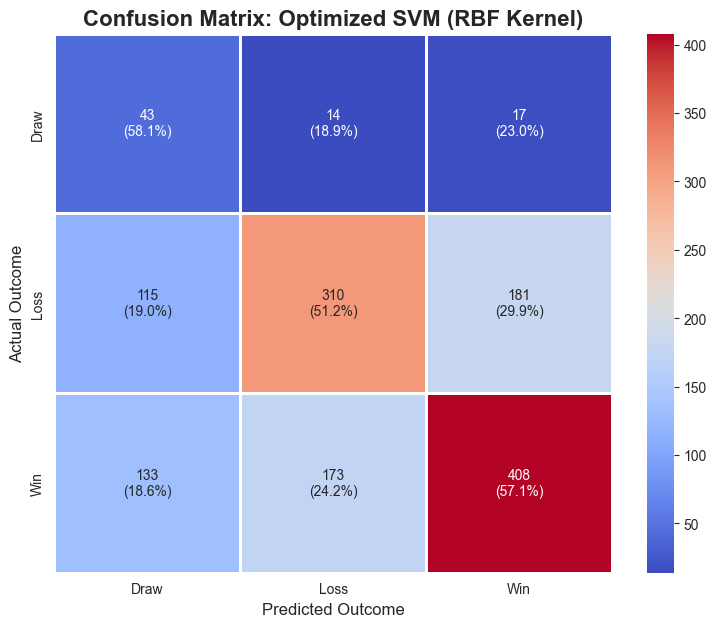

In [6]:
# ===========================================================
# 6.1 Confusion Matrix Visualization
# ===========================================================
from sklearn.metrics import confusion_matrix
import numpy as np

cm = confusion_matrix(y_test, y_pred_optimized)
cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
labels = le.classes_

plt.figure(figsize=(9, 7))
sns.heatmap(
    cm,
    annot=np.array([[f"{v}\n({p:.1%})" for v, p in zip(row_counts, row_percent)]
                    for row_counts, row_percent in zip(cm, cm_percent)]),
    fmt='',
    cmap='coolwarm',
    xticklabels=labels,
    yticklabels=labels,
    linewidths=1,
    linecolor='white'
)

plt.title('Confusion Matrix: Optimized SVM (RBF Kernel)', fontsize=16, weight='bold')
plt.ylabel('Actual Outcome', fontsize=12)
plt.xlabel('Predicted Outcome', fontsize=12)
plt.show()

### 6.2 Decision Boundary Visualization (Inspired by R/kernlab)

To understand how the SVM makes decisions, we visualize its decision boundary. We project the complex, high-dimensional model onto a 2D plane defined by the two most intuitive features: `ELO_Diff` and `Opening_WR`. This plot is styled to replicate the clarity of the `kernlab` visualizations, showing the regions where the model would classify a new game as a Win, Loss, or Draw.

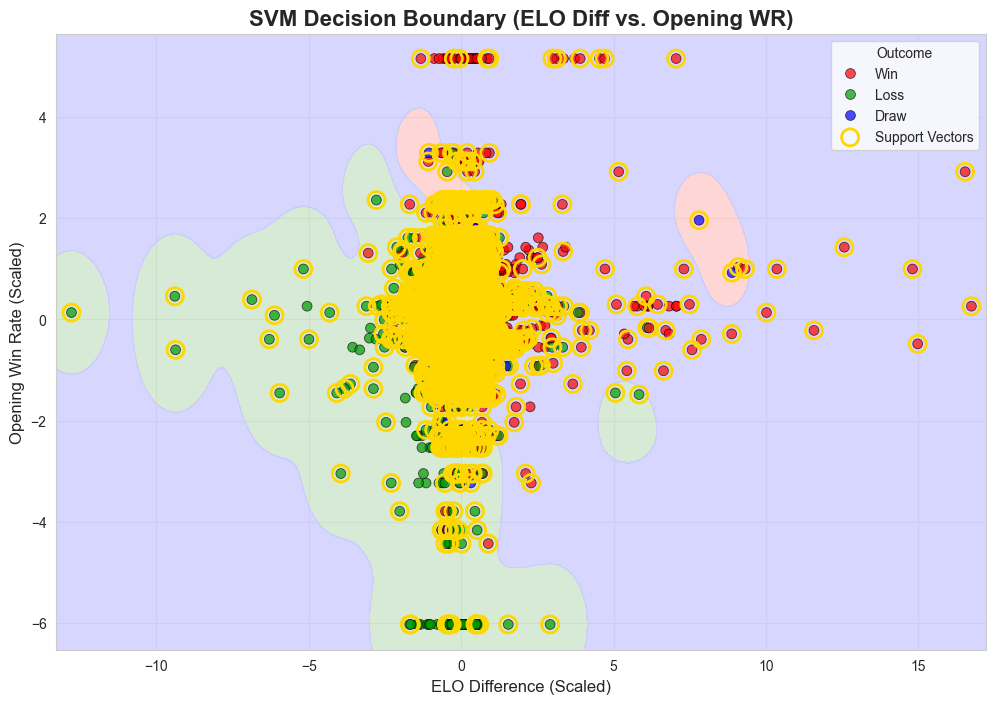

In [7]:
# ===========================================================
# 6.2 Enhanced SVM Decision Boundary Plot (R/kernlab style)
# ===========================================================
from matplotlib.colors import ListedColormap

# --- Prepare 2D data for visualization ---
# Make a copy of the raw dataset
df_vis = df_raw.copy()

# Compute average win rate per opening (for visualization only)
opening_stats_vis = (
    df_vis.groupby("Opening_ECO")["Score"]
    .agg("mean")
    .reset_index(name="Opening_WR_vis")
)

# Merge it back to the dataset
df_vis = df_vis.merge(opening_stats_vis, on="Opening_ECO", how="left")

# Select the two features for plotting
X_2d = df_vis[['ELO_Diff', 'Opening_WR_vis']].copy()

# Encode target using the same LabelEncoder used in preprocessing
y_2d = le.transform(df_vis['Outcome'])

# Scale the features
scaler_2d = StandardScaler()
X_2d_scaled = scaler_2d.fit_transform(X_2d)

# Train an optimized SVM model (using the best parameters found earlier)
svm_2d_optimized = SVC(**grid.best_params_, random_state=42, probability=True)
svm_2d_optimized.fit(X_2d_scaled, y_2d)


# --- Decision Boundary Plot Function ---
def plot_decision_boundary_kernlab_style(X, y, model, title, le=None, feature_names=None):
    h = 0.02  # Step size in mesh
    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    # Predict over the grid
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Color palettes (inspired by RColorBrewer "Set1")
    cmap_light = ListedColormap(['#FFCCCC', '#CCE5CC', '#CCCCFF'])  # light red, green, blue
    cmap_bold = ['#FF0000', '#009900', '#0000FF']  # red, green, blue

    plt.figure(figsize=(12, 8))

    # Plot the decision surface
    plt.contourf(xx, yy, Z, cmap=cmap_light, alpha=0.8)

    # Scatter actual data points
    hue_labels = le.inverse_transform(y) if le is not None else y
    sns.scatterplot(
        x=X[:, 0], y=X[:, 1],
        hue=hue_labels,
        palette=cmap_bold,
        alpha=0.7, edgecolor="k", s=50
    )

    # Highlight support vectors
    sv = model.support_vectors_
    plt.scatter(
        sv[:, 0], sv[:, 1],
        s=150, facecolors='none', edgecolors='gold', linewidths=2,
        label='Support Vectors'
    )

    # Labels and legend
    plt.title(title, fontsize=16, weight='bold')
    plt.xlabel(feature_names[0] if feature_names else 'Feature 1', fontsize=12)
    plt.ylabel(feature_names[1] if feature_names else 'Feature 2', fontsize=12)
    plt.legend(title='Outcome')
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    plt.show()


# --- Plot the SVM decision boundary ---
plot_decision_boundary_kernlab_style(
    X_2d_scaled, y_2d, svm_2d_optimized,
    title='SVM Decision Boundary (ELO Diff vs. Opening WR)',
    le=le,
    feature_names=['ELO Difference (Scaled)', 'Opening Win Rate (Scaled)']
)


## 7. Comparing Kernels and Conclusion

Finally, we compare the optimized RBF kernel against a simple Linear kernel to demonstrate the value of non-linear separation for this dataset.

Kernel: Optimized RBF   | Accuracy: 0.5459
Kernel: Linear          | Accuracy: 0.5143


C:\Users\Niteesh\AppData\Local\Temp\ipykernel_15012\3863031150.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(x='Kernel', y='Accuracy', data=kernels_df, palette='coolwarm', edgecolor='k')


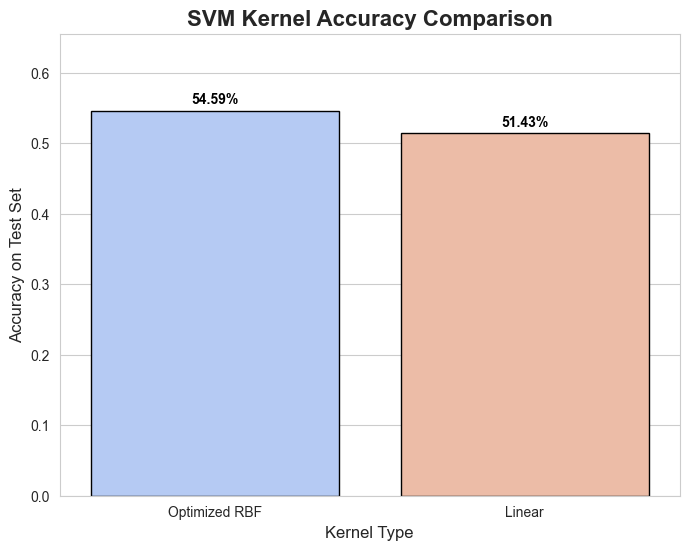

In [8]:
# ===========================================================
# 7. Kernel Comparison: Accuracy Evaluation & Visualization
# ===========================================================
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

kernels_to_compare = [
    ('Optimized RBF', svm_optimized),
    ('Linear', SVC(kernel='linear', C=1.0, class_weight='balanced', random_state=42).fit(X_train, y_train))
]

scores = {}
for name, model in kernels_to_compare:
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    scores[name] = accuracy
    print(f"Kernel: {name:<15} | Accuracy: {accuracy:.4f}")

kernels_df = pd.DataFrame(list(scores.items()), columns=['Kernel', 'Accuracy'])

plt.figure(figsize=(8, 6))
barplot = sns.barplot(x='Kernel', y='Accuracy', data=kernels_df, palette='coolwarm', edgecolor='k')
for index, row in kernels_df.iterrows():
    barplot.text(index, row.Accuracy + 0.01, f'{row.Accuracy:.2%}', color='black', ha="center", weight='bold')

plt.ylim(0, max(kernels_df['Accuracy']) * 1.2 if not kernels_df.empty else 1)
plt.title('SVM Kernel Accuracy Comparison', fontsize=16, weight='bold')
plt.ylabel('Accuracy on Test Set', fontsize=12)
plt.xlabel('Kernel Type', fontsize=12)
plt.show()

### Conclusion

The comparison confirms that the **RBF kernel performs better** than the Linear kernel. This indicates that the relationships between factors like ELO difference, historical opening performance, and game outcome are complex and non-linear. The SVM's ability to find non-linear decision boundaries via the Kernel Trick is essential for achieving the best predictive accuracy on this type of statistical chess data.

## 8. Further Analysis: Advanced Hyperparameter Tuning with Bayesian Optimization

The `GridSearchCV` we used earlier is a powerful tool, but it performs a "brute-force" search over a limited, pre-defined grid of parameters. A more modern and efficient approach is **Bayesian Optimization**, which intelligently selects which hyperparameters to try next based on the results of previous attempts.

This method can explore a much wider and more continuous range of values for `C` and `gamma`, potentially finding a better combination that `GridSearchCV` might have missed. We will use the `scikit-optimize` library's `BayesSearchCV` to perform this advanced tuning.

**Note:** You may need to install the library first by running: `pip install scikit-optimize`

In [9]:
# ===========================================================
# 8. Advanced SVM Tuning: Bayesian Optimization with BayesSearchCV
# ===========================================================
from skopt import BayesSearchCV
from skopt.space import Real, Categorical
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import warnings

# BayesSearchCV can sometimes raise warnings that are safe to ignore
warnings.filterwarnings("ignore", category=UserWarning)

# --- 1. Define the Search Space ---
# We define a continuous range for each hyperparameter.
search_spaces = {
    'C': Real(1e-3, 1e+3, prior='log-uniform'),      # Search C from 0.001 to 1000
    'gamma': Real(1e-4, 1e+1, prior='log-uniform'),  # Search gamma from 0.0001 to 10
    'kernel': Categorical(['rbf']),
    'class_weight': Categorical(['balanced'])
}

# --- 2. Set up and Run Bayesian Optimization ---
# n_iter controls how many combinations are tested. 50 is a robust number.
bayes_search = BayesSearchCV(
    estimator=SVC(random_state=42, probability=True),
    search_spaces=search_spaces,
    n_iter=50,       # Number of parameter settings to sample
    cv=5,            # Use 5-fold cross-validation for more stable results
    n_jobs=-1,       # Use all available CPU cores
    verbose=1,       # Set to 1 for less verbose output
    random_state=42
)

print("--- Starting Bayesian Optimization for RBF Kernel ---")
bayes_search.fit(X_train, y_train)

# --- 3. Evaluate the Best Model Found ---
print("\n✅ Bayesian Optimization Search Completed")
print(f"Best Parameters Found: {bayes_search.best_params_}")
print(f"Best Cross-Validation Score: {bayes_search.best_score_:.4f}")

# Compare with the test set
svm_bayes_optimized = bayes_search.best_estimator_
y_pred_bayes = svm_bayes_optimized.predict(X_test)
accuracy_bayes = accuracy_score(y_test, y_pred_bayes)

print("\n--- Optimized RBF Kernel Performance (from BayesSearch) ---")
print(f"Accuracy on Test Set: {accuracy_bayes:.4f}")

print("\nClassification Report (BayesSearch Model):")
print(classification_report(y_test, y_pred_bayes, target_names=le.classes_))

--- Starting Bayesian Optimization for RBF Kernel ---
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fi

In [10]:

# ===========================================================
# 1. Prepare the Improved Dataset (FINAL CORRECTED VERSION)
# ===========================================================

# Start from df_raw, which is globally available from the first cell
print(f"Original number of games: {len(df_raw)}")
df_improved = df_raw[df_raw['Moves'] > 10].copy()
print(f"Games after filtering: {len(df_improved)}")

# --- Add 'Recent Form' Feature ---
df_improved = df_improved.sort_index().reset_index(drop=True)
df_improved['Recent_Form_WR'] = df_improved.groupby('Player_Name')['Score'].transform(
    lambda x: x.shift(1).rolling(window=15, min_periods=5).mean()
)
player_avg_score = df_improved.groupby('Player_Name')['Score'].transform('mean')
df_improved['Recent_Form_WR'].fillna(player_avg_score, inplace=True)
df_improved['Recent_Form_WR'].fillna(0.5, inplace=True)

# --- Re-create historical and opening group features (Robust Method) ---
# This section now correctly replicates the logic from your original notebook
opening_stats_imp = df_improved.groupby("Opening_ECO")["Score"].agg(["mean", "count"])
opening_stats_imp.columns = ["Opening_WR", "Opening_Count"]
frequent_openings_imp = opening_stats_imp[opening_stats_imp["Opening_Count"] >= MIN_OPENING_COUNT].index
avg_rare_wr_imp = opening_stats_imp[opening_stats_imp["Opening_Count"] < MIN_OPENING_COUNT]["Opening_WR"].mean()

opponent_stats_imp = df_improved.groupby("Opponent_Name")["Score"].agg(["mean", "count"])
opponent_stats_imp.columns = ["Rival_WR", "Rival_Count"]

# Step 1: Create the new, grouped opening column
df_improved["Opening_Grouped"] = df_improved["Opening_ECO"].apply(lambda x: x if x in frequent_openings_imp else "Z_Other")

# Step 2: Merge the statistical features
df_improved = df_improved.merge(opening_stats_imp[["Opening_WR"]], on="Opening_ECO", how="left")
df_improved.loc[df_improved["Opening_Grouped"] == "Z_Other", "Opening_WR"] = avg_rare_wr_imp

df_improved = df_improved.merge(opponent_stats_imp[["Rival_WR", "Rival_Count"]], on="Opponent_Name", how="left")
df_improved["Rival_WR"] = df_improved.apply(lambda row: row["Rival_WR"] if row["Rival_Count"] >= MIN_RIVAL_COUNT else 0.5, axis=1)

# Step 3: Create the final modeling DataFrame by SELECTING the columns we want to keep.
# This is a safer approach than dropping.
columns_to_keep = [
    'Player_Name', 'Outcome', 'Color', 'ELO_Diff', 'Opponent_Rating',
    'Moves', 'Opening_WR', 'Rival_WR', 'Recent_Form_WR',
    'Opening_Grouped' # Keep the grouped version
]
df_model_improved = df_improved[columns_to_keep].copy()

# Step 4: Rename 'Opening_Grouped' to 'Opening_ECO' for consistency.
df_model_improved.rename(columns={"Opening_Grouped": "Opening_ECO"}, inplace=True)

print("\\n✅ Created new, improved dataset for modeling.")
display(df_model_improved.head())

Original number of games: 6966
Games after filtering: 6904
\n✅ Created new, improved dataset for modeling.


C:\Users\Niteesh\AppData\Local\Temp\ipykernel_15012\1819300756.py:16: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_improved['Recent_Form_WR'].fillna(player_avg_score, inplace=True)
C:\Users\Niteesh\AppData\Local\Temp\ipykernel_15012\1819300756.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always b

,Player_Name,Outcome,Color,ELO_Diff,Opponent_Rating,Moves,Opening_WR,Rival_WR,Recent_Form_WR,Opening_ECO
0,LucienEvans,Win,Black,12,2226,68,0.564605,0.5,0.522928,A00
1,LucienEvans,Loss,White,-7,2251,86,0.564605,0.5,0.522928,A00
2,LucienEvans,Loss,White,-171,2418,124,0.564605,0.5,0.522928,A00
3,LucienEvans,Win,Black,13,2228,60,0.531690,0.5,0.522928,A01
4,LucienEvans,Win,White,83,2154,49,0.564605,0.5,0.522928,A00


In [11]:
# ===========================================================
# 2. Preprocess the Improved Dataset (FINAL RECOMMENDED VERSION)
# ===========================================================
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd

# ✅ Encode target variable
le_imp = LabelEncoder()
df_model_improved['Outcome_Encoded'] = le_imp.fit_transform(df_model_improved['Outcome'])

# ✅ One-hot encode categorical columns, INCLUDING the Opening_ECO
# THIS IS THE CRUCIAL FIX
categorical_cols_imp = ['Color', 'Player_Name', 'Opening_ECO']
df_processed_imp = pd.get_dummies(df_model_improved, columns=categorical_cols_imp, drop_first=True)

# ✅ Drop unnecessary columns (the 'errors' part is good practice but not strictly needed now)
X_imp = df_processed_imp.drop(columns=['Outcome', 'Outcome_Encoded'], errors='ignore')
y_imp = df_processed_imp['Outcome_Encoded']

# ✅ Scale numerical features
numerical_cols_imp = ['Opponent_Rating', 'Moves', 'ELO_Diff', 'Opening_WR', 'Rival_WR', 'Recent_Form_WR']
scaler_imp = StandardScaler()

# Your robust check for existing columns is great, we'll keep it
numerical_cols_present = [col for col in numerical_cols_imp if col in X_imp.columns]
X_imp[numerical_cols_present] = scaler_imp.fit_transform(X_imp[numerical_cols_present])

# ✅ Split dataset (80/20)
X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(
    X_imp, y_imp, test_size=0.2, random_state=42, stratify=y_imp
)

print("✅ Improved dataset preprocessed and split successfully.")
print(f"Training set shape: {X_train_imp.shape}, Test set shape: {X_test_imp.shape}")

✅ Improved dataset preprocessed and split successfully.
Training set shape: (5523, 116), Test set shape: (1381, 116)


In [12]:
#### **New Code Cell 3: Re-run Bayesian Search on Improved Data**
# ===========================================================
# 3. Re-run Bayesian Search on the Improved Data
# ===========================================================
from skopt import BayesSearchCV
from skopt.space import Real, Categorical
import warnings
warnings.filterwarnings("ignore", category=UserWarning)


search_spaces = {
    'C': Real(1e-3, 1e+3, prior='log-uniform'),
    'gamma': Real(1e-4, 1e+1, prior='log-uniform'),
    'kernel': Categorical(['rbf']),
    'class_weight': Categorical(['balanced'])
}
bayes_search_imp = BayesSearchCV(
    estimator=SVC(random_state=42, probability=True),
    search_spaces=search_spaces,
    n_iter=50, cv=5, n_jobs=-1, verbose=1, random_state=42
)

print("--- Starting Bayesian Optimization on IMPROVED Data ---")
bayes_search_imp.fit(X_train_imp, y_train_imp)

print(f"\\nBest Parameters Found: {bayes_search_imp.best_params_}")

y_pred_bayes_imp = bayes_search_imp.predict(X_test_imp)
accuracy_bayes_imp = accuracy_score(y_test_imp, y_pred_bayes_imp)

print(f"\\n✅ --- SVM Accuracy on IMPROVED Data: {accuracy_bayes_imp:.4f} ---")
print("\\nClassification Report (Improved SVM Model):")
print(classification_report(y_test_imp, y_pred_bayes_imp, target_names=le_imp.classes_))

--- Starting Bayesian Optimization on IMPROVED Data ---
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


In [13]:


#### **New Code Cell 4: Run XGBoost on Improved Data**
# ===========================================================
# 4. Run XGBoost on the Improved Data
# ===========================================================
import xgboost as xgb

print("\\n--- Training XGBoost on IMPROVED Data ---")
xgb_model_imp = xgb.XGBClassifier(
    objective='multi:softprob', eval_metric='mlogloss',
    use_label_encoder=False, random_state=42
)

xgb_model_imp.fit(X_train_imp, y_train_imp)
y_pred_xgb_imp = xgb_model_imp.predict(X_test_imp)
accuracy_xgb_imp = accuracy_score(y_test_imp, y_pred_xgb_imp)

print(f"\\n✅ --- XGBoost Accuracy on IMPROVED Data: {accuracy_xgb_imp:.4f} ---")
print("\\nClassification Report (Improved XGBoost Model):")
print(classification_report(y_test_imp, y_pred_xgb_imp, target_names=le_imp.classes_))

\n--- Training XGBoost on IMPROVED Data ---
\n✅ --- XGBoost Accuracy on IMPROVED Data: 0.6517 ---
\nClassification Report (Improved XGBoost Model):
              precision    recall  f1-score   support

        Draw       0.27      0.08      0.12        74
        Loss       0.64      0.62      0.63       598
         Win       0.67      0.74      0.70       709

    accuracy                           0.65      1381
   macro avg       0.53      0.48      0.49      1381
weighted avg       0.64      0.65      0.64      1381



--- Comparing Final Model Performance on the Improved Dataset ---
Model: Improved RBF (Bayes)   | Accuracy: 0.5757
Model: Improved XGBoost       | Accuracy: 0.6517
Model: Improved Linear        | Accuracy: 0.5250


C:\Users\Niteesh\AppData\Local\Temp\ipykernel_15012\2590931053.py:44: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


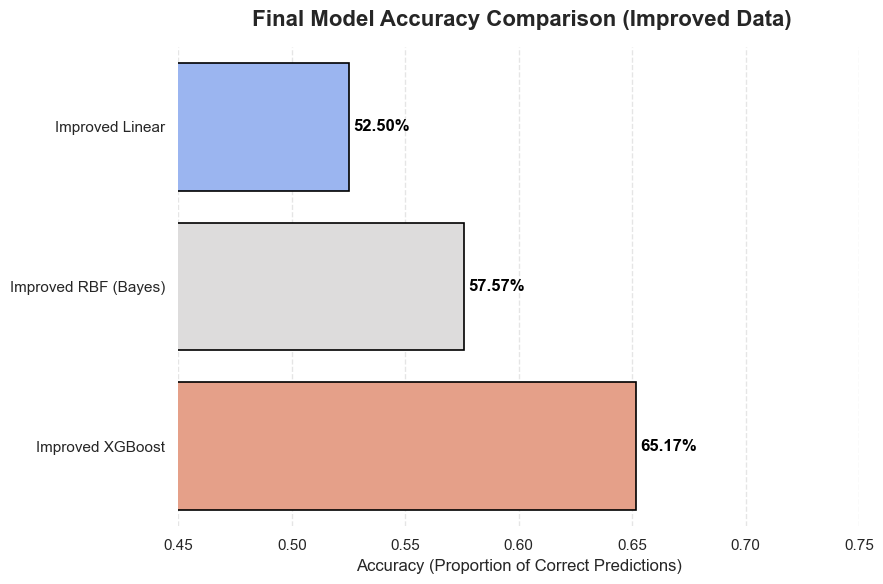

In [14]:
# ===========================================================
# 🌟 Final Accuracy Comparison — Enhanced Visualization
# ===========================================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC

print("--- Comparing Final Model Performance on the Improved Dataset ---")

# 1. Train the final missing model: Linear SVM
linear_svm_imp = SVC(kernel='linear', class_weight='balanced', random_state=42)
linear_svm_imp.fit(X_train_imp, y_train_imp)

# 2. Collect all models
models_to_compare = {
    "Improved RBF (Bayes)": bayes_search_imp.best_estimator_,
    "Improved XGBoost": xgb_model_imp,
    "Improved Linear": linear_svm_imp
}

# 3. Compute accuracy scores
scores_imp = {}
for name, model in models_to_compare.items():
    y_pred = model.predict(X_test_imp)
    accuracy = accuracy_score(y_test_imp, y_pred)
    scores_imp[name] = accuracy
    print(f"Model: {name:<22} | Accuracy: {accuracy:.4f}")

# 4. Prepare data for plotting
results_df = (
    pd.DataFrame(list(scores_imp.items()), columns=['Model', 'Accuracy'])
    .sort_values('Accuracy', ascending=True)  # ascending for horizontal bars
    .reset_index(drop=True)
)

# 5. Visualization
plt.figure(figsize=(9, 6))
sns.set_theme(style="whitegrid")

bar_colors = sns.color_palette("coolwarm", n_colors=len(results_df))

barplot = sns.barplot(
    x="Accuracy",
    y="Model",
    data=results_df,
    palette=bar_colors,
    edgecolor='black',
    linewidth=1.2
)

# Add percentage labels on each bar
for i, row in enumerate(results_df.itertuples()):
    plt.text(
        row.Accuracy + 0.002,  # position slightly after bar end
        i,
        f"{row.Accuracy * 100:.2f}%",
        va='center',
        ha='left',
        fontsize=12,
        fontweight='bold',
        color='black'
    )

# Beautify chart
plt.xlim(0.45, 0.75)  # since accuracies are between 0.5–0.7
plt.title(" Final Model Accuracy Comparison (Improved Data)", fontsize=16, weight='bold', pad=15)
plt.xlabel("Accuracy (Proportion of Correct Predictions)", fontsize=12)
plt.ylabel("")
plt.grid(axis='x', linestyle='--', alpha=0.5)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()


Note: you may need to restart the kernel to use updated packages.
All libraries loaded successfully.



[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip
illegal san: 'dxc4' in 8/p1p1Bp1p/2p2P2/7k/6R1/5R2/PrP3KP/8 w - - 2 39 while parsing <Game at 0x244315cb760 ('nit4_S' vs. 'Mirta1968', '2022.12.31' at 'Chess.com')>
illegal san: 'd3' in 3K3r/8/3k4/8/8/8/8/8 w - - 26 68 while parsing <Game at 0x244315bb970 ('nit4_S' vs. 'Chaves1967', '2023.01.25' at 'Chess.com')>
illegal san: '3b1' in 5Q2/ppp3r1/2n3R1/3kP3/7p/PP2n2P/3P4/4R2K b - - 0 42 while parsing <Game at 0x244653ccbe0 ('elmarpatricio' vs. 'nit4_S', '2023.02.28' at 'Chess.com')>
illegal san: '1b2r' in 8/pp3k2/2pp4/4p1R1/4P2B/2Pq3P/1P3PK1/8 w - - 4 43 while parsing <Game at 0x244319aa610 ('dragonbankrs' vs. 'nit4_S', '2023.03.31' at 'Chess.com')>
illegal san: 'd5' in 3r4/p5k1/2r1Bp2/4p3/7N/2p3P1/P6P/2R4K w - - 5 39 while parsing <Game at 0x244388cd970 ('nit4_S' vs. 'Lexnytate', '2023.05.01' at 'Chess.com')>
illegal san: 'O-O' in 8/R7/2p1b3/1p6/5k2/4pp2/PP3K2/8 w -

✅ Successfully loaded a total of 6966 games.
--- Starting Advanced Feature Engineering ---
Games after filtering short games: 6922
✅ Feature engineering complete. Final dataset shape for modeling: (6922, 10)
✅ Data preprocessed and split successfully.
Training set shape: (5537, 91)
Test set shape: (1385, 91)
Data type of training data: [dtype('float32')]

--- Training Random Forest ---


C:\Users\Niteesh\AppData\Local\Temp\ipykernel_7768\3961137056.py:110: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_feat['Recent_Form_WR'].fillna(player_avg_score, inplace=True)
C:\Users\Niteesh\AppData\Local\Temp\ipykernel_7768\3961137056.py:112: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behav

Random Forest Accuracy: 0.5740

--- Training XGBoost ---
XGBoost Accuracy: 0.6520

--- Training LightGBM ---
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000832 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 875
[LightGBM] [Info] Number of data points in the train set: 5537, number of used features: 47
[LightGBM] [Info] Start training from score -2.932233
[LightGBM] [Info] Start training from score -0.835151
[LightGBM] [Info] Start training from score -0.667649
LightGBM Accuracy: 0.7047

--- Training and Tuning SVM with Bayesian Optimization ---
Tuned SVM Accuracy: 0.5574
Best SVM Params: OrderedDict([('C', 0.7311959687031307), ('class_weight', 'balanced'), ('gamma', 1.1909009086089535), ('kernel', 'rbf')])

--- Training Deep Learning MLP Model ---


Deep Learning MLP Accuracy: 0.6455

--- Training Stacking Ensemble Model ---
Stacking Ensemble Accuracy: 0.6209


C:\Users\Niteesh\AppData\Local\Temp\ipykernel_7768\3961137056.py:335: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  barplot = sns.barplot(


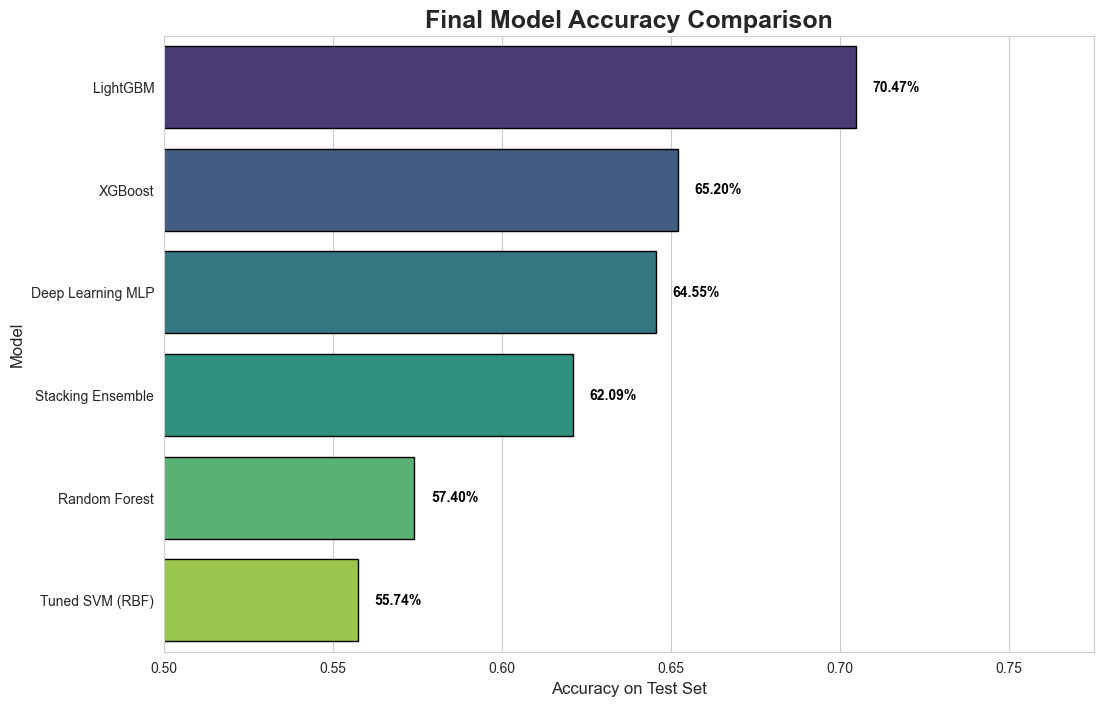


--- Final Model Leaderboard ---
               Model  Accuracy
0           LightGBM  0.704693
1            XGBoost  0.651986
2  Deep Learning MLP  0.645487
3  Stacking Ensemble  0.620939
4      Random Forest  0.574007
5    Tuned SVM (RBF)  0.557401


In [ ]:

# ===========================================================
# 0. SETUP: Install necessary libraries
# ===========================================================
# Use the magic %pip install to ensure required packages are available.
# This is required to fix ModuleNotFoundError for packages like lightgbm.
import os
import pandas as pd
import numpy as np
import chess.pgn
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# Scikit-learn imports
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

# Advanced model imports
import xgboost as xgb
import lightgbm as lgb
from skopt import BayesSearchCV
from skopt.space import Real, Categorical

# Deep Learning imports
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# Configure settings
warnings.filterwarnings("ignore", category=UserWarning)
sns.set_style("whitegrid")
pd.set_option('display.max_columns', None)

print("All libraries loaded successfully.")
# ===========================================================
# 1. LOAD AND PARSE ALL PGN FILES (Same as original)
# ===========================================================
# --- Configuration ---
PLAYER_NAMES = ['LucienEvans', 'nit4_S'] # The user accounts we are analyzing
PGN_FILES = [
    # IMPORTANT: Replace these paths with the actual locations of your files
    r'E:\\Puducherry Technological University\\MLS\\SVM DEMO\\lichess_games.pgn',
    r'E:\\Puducherry Technological University\\MLS\\SVM DEMO\\db\\nit4_S_chesscom.pgn',
    r'E:\\Puducherry Technological University\\MLS\\SVM DEMO\\db\\nit4_S_lichess.pgn'
]

# --- Load Multiple PGNs ---
all_games = []
for pgn_path in PGN_FILES:
    if not os.path.exists(pgn_path):
        print(f"⚠️ WARNING: PGN file not found, skipping: {pgn_path}")
        continue
    with open(pgn_path, encoding="utf-8") as pgn_file:
        while True:
            game = chess.pgn.read_game(pgn_file)
            if game is None: break
            white = game.headers.get("White")
            black = game.headers.get("Black")
            matched_player = next((p for p in PLAYER_NAMES if p in [white, black]), None)
            if not matched_player: continue
            result = game.headers.get("Result")
            if result not in ["1-0", "0-1", "1/2-1/2"]: continue
            is_white = (white == matched_player)
            try:
                player_elo = int(game.headers.get("WhiteElo") if is_white else game.headers.get("BlackElo"))
                opponent_elo = int(game.headers.get("BlackElo") if is_white else game.headers.get("WhiteElo"))
            except (TypeError, ValueError):
                continue
            if result == "1/2-1/2": outcome, score = "Draw", 0.5
            elif (is_white and result == "1-0") or (not is_white and result == "0-1"): outcome, score = "Win", 1.0
            else: outcome, score = "Loss", 0.0
            all_games.append({
                "Player_Name": matched_player, "Outcome": outcome, "Score": score,
                "Color": "White" if is_white else "Black", "Opening_ECO": game.headers.get("ECO", "UNK"),
                "Opponent_Name": black if is_white else white, "ELO_Diff": player_elo - opponent_elo,
                "Opponent_Rating": opponent_elo, "Moves": len(list(game.mainline_moves())),
            })

df_raw = pd.DataFrame(all_games)
if df_raw.empty:
    raise ValueError("No valid games found in the PGN files. Check your file paths.")
print(f"✅ Successfully loaded a total of {len(df_raw)} games.")

# ===========================================================
# 2. ADVANCED FEATURE ENGINEERING
# ===========================================================
print("--- Starting Advanced Feature Engineering ---")

# --- Step 1: Data Cleaning and Filtering ---
# Remove very short games which are often resignations or tests
df_feat = df_raw[df_raw['Moves'] > 6].copy()
print(f"Games after filtering short games: {len(df_feat)}")

# --- Step 2: Create 'Recent Form' Feature (Rolling Win Rate) ---
# Sort by index to approximate chronological order for this calculation
df_feat = df_feat.sort_index().reset_index(drop=True)
df_feat['Recent_Form_WR'] = df_feat.groupby('Player_Name')['Score'].transform(
    lambda x: x.shift(1).rolling(window=20, min_periods=5).mean()
)
# Fill NaNs for players at the start of their record with their overall average
player_avg_score = df_feat.groupby('Player_Name')['Score'].transform('mean')
df_feat['Recent_Form_WR'].fillna(player_avg_score, inplace=True)
# Fill any remaining NaNs (e.g., a player with <5 games) with a neutral 0.5
df_feat['Recent_Form_WR'].fillna(0.5, inplace=True)

# --- Step 3: Create Robust Historical Win Rate Features ---
MIN_OPENING_COUNT = 10
MIN_RIVAL_COUNT = 5

# Opening Win Rate
opening_stats = df_feat.groupby("Opening_ECO")["Score"].agg(["mean", "count"]).rename(columns={"mean": "Opening_WR", "count": "Opening_Count"})
df_feat = df_feat.merge(opening_stats, on="Opening_ECO", how="left")
# Group rare openings into an 'Other' category to prevent noise
df_feat['Opening_Grouped'] = np.where(df_feat['Opening_Count'] < MIN_OPENING_COUNT, 'Z_Other', df_feat['Opening_ECO'])
# Use the grouped win rate for rare openings
opening_grouped_wr = df_feat.groupby('Opening_Grouped')['Score'].transform('mean')
df_feat['Opening_WR'] = np.where(df_feat['Opening_Grouped'] == 'Z_Other', opening_grouped_wr, df_feat['Opening_WR'])


# Rival Win Rate
opponent_stats = df_feat.groupby("Opponent_Name")["Score"].agg(["mean", "count"]).rename(columns={"mean": "Rival_WR", "count": "Rival_Count"})
df_feat = df_feat.merge(opponent_stats, on="Opponent_Name", how="left")
# For new or rare opponents, assume a neutral 0.5 win rate
df_feat['Rival_WR'] = np.where(df_feat['Rival_Count'].fillna(0) < MIN_RIVAL_COUNT, 0.5, df_feat['Rival_WR'])


# --- Step 4: Final DataFrame for Modeling ---
# Select only the columns needed for the model
features_to_use = [
    'Player_Name', 'Outcome', 'Color', 'ELO_Diff', 'Opponent_Rating',
    'Moves', 'Opening_WR', 'Rival_WR', 'Recent_Form_WR',
    'Opening_Grouped' # Use the grouped version
]
df_model = df_feat[features_to_use].copy()
df_model.rename(columns={"Opening_Grouped": "Opening_ECO"}, inplace=True)

# Drop rows with any remaining missing values (should be minimal)
df_model.dropna(inplace=True)

print(f"✅ Feature engineering complete. Final dataset shape for modeling: {df_model.shape}")
df_model.head()

# ===========================================================
# 3. UNIFIED PREPROCESSING & DATA SPLITTING (CORRECTED VERSION)
# ===========================================================

# --- Target Encoding ---
le = LabelEncoder()
df_model['Outcome_Encoded'] = le.fit_transform(df_model['Outcome'])

# --- Feature Preparation ---
# One-hot encode ALL categorical features. This is crucial.
categorical_cols = ['Color', 'Player_Name', 'Opening_ECO']
df_processed = pd.get_dummies(df_model, columns=categorical_cols, drop_first=True)

# Separate features (X) and target (y)
X = df_processed.drop(columns=['Outcome', 'Outcome_Encoded'])
y = df_processed['Outcome_Encoded']

# --- Train-Test Split ---
# Stratify to ensure class distribution is the same in train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# --- Scaling Numerical Features ---
# Identify numerical columns AFTER one-hot encoding
numerical_cols = ['Opponent_Rating', 'Moves', 'ELO_Diff', 'Opening_WR', 'Rival_WR', 'Recent_Form_WR']
scaler = StandardScaler()

# Fit scaler ONLY on training data and transform both train and test data
X_train[numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
X_test[numerical_cols] = scaler.transform(X_test[numerical_cols])

# ✅ FIX: Explicitly convert the final dataframes to a TensorFlow-compatible type (float32)
# This resolves the "Unsupported object type float" ValueError.
X_train = X_train.astype(np.float32)
X_test = X_test.astype(np.float32)


print("✅ Data preprocessed and split successfully.")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")
print(f"Data type of training data: {X_train.dtypes.unique()}") # Should now show [float32]


# ===========================================================
# 4. MODEL GAUNTLET: Training Multiple Classifiers
# ===========================================================

# Dictionary to store results
model_scores = {}

# --- Model 1: Random Forest ---
print("\n--- Training Random Forest ---")
rf_model = RandomForestClassifier(n_estimators=200, random_state=42, class_weight='balanced', n_jobs=-1, max_depth=10)
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)
accuracy_rf = accuracy_score(y_test, y_pred_rf)
model_scores['Random Forest'] = accuracy_rf
print(f"Random Forest Accuracy: {accuracy_rf:.4f}")

# --- Model 2: XGBoost ---
print("\n--- Training XGBoost ---")
xgb_model = xgb.XGBClassifier(objective='multi:softprob', eval_metric='mlogloss', use_label_encoder=False, random_state=42, n_estimators=200, learning_rate=0.1, max_depth=5)
xgb_model.fit(X_train, y_train)
y_pred_xgb = xgb_model.predict(X_test)
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
model_scores['XGBoost'] = accuracy_xgb
print(f"XGBoost Accuracy: {accuracy_xgb:.4f}")

# --- Model 3: LightGBM ---
print("\n--- Training LightGBM ---")
lgb_model = lgb.LGBMClassifier(objective='multiclass', random_state=42, n_estimators=200, learning_rate=0.1, num_leaves=31)
lgb_model.fit(X_train, y_train)
y_pred_lgb = lgb_model.predict(X_test)
accuracy_lgb = accuracy_score(y_test, y_pred_lgb)
model_scores['LightGBM'] = accuracy_lgb
print(f"LightGBM Accuracy: {accuracy_lgb:.4f}")

# --- Model 4: Tuned SVM (using Bayesian Search) ---
print("\n--- Training and Tuning SVM with Bayesian Optimization ---")
# This is computationally expensive and may take a few minutes
search_spaces = {
    'C': Real(1e-2, 1e+2, prior='log-uniform'),
    'gamma': Real(1e-3, 1e+1, prior='log-uniform'),
    'kernel': Categorical(['rbf']),
    'class_weight': Categorical(['balanced'])
}
bayes_search = BayesSearchCV(
    estimator=SVC(random_state=42, probability=True),
    search_spaces=search_spaces,
    n_iter=32, cv=3, n_jobs=-1, verbose=0, random_state=42
)
bayes_search.fit(X_train, y_train)
svm_tuned = bayes_search.best_estimator_
y_pred_svm = svm_tuned.predict(X_test)
accuracy_svm = accuracy_score(y_test, y_pred_svm)
model_scores['Tuned SVM (RBF)'] = accuracy_svm
print(f"Tuned SVM Accuracy: {accuracy_svm:.4f}")
print(f"Best SVM Params: {bayes_search.best_params_}")

# ===========================================================
# 5. DEEP LEARNING MODEL: Multi-Layer Perceptron (MLP)
# ===========================================================
print("\n--- Training Deep Learning MLP Model ---")

# Prepare data for Keras (target needs to be one-hot encoded)
y_train_keras = to_categorical(y_train)
y_test_keras = to_categorical(y_test)
num_classes = y_train_keras.shape[1]
input_dim = X_train.shape[1]

# Define the model architecture
dl_model = Sequential([
    Dense(128, input_dim=input_dim, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu'),
    BatchNormalization(),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax') # Softmax for multi-class classification
])

# Compile the model
dl_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Use Early Stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

# Train the model
history = dl_model.fit(
    X_train, y_train_keras,
    validation_split=0.15,
    epochs=150,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=0 # Set to 1 to see training progress
)

# Evaluate the model
loss, accuracy_dl = dl_model.evaluate(X_test, y_test_keras, verbose=0)
model_scores['Deep Learning MLP'] = accuracy_dl
print(f"Deep Learning MLP Accuracy: {accuracy_dl:.4f}")

# ===========================================================
# 6. ENSEMBLE MODEL: Stacking Classifier
# ===========================================================
print("\n--- Training Stacking Ensemble Model ---")

# Define the base models (we can reuse the ones we trained)
estimators = [
    ('rf', rf_model),
    ('xgb', xgb_model),
    ('lgbm', lgb_model),
    ('svm', svm_tuned)
]

# The meta-model learns from the predictions of the base models
# Logistic Regression is a simple, robust choice for the final layer.
stacking_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(class_weight='balanced'),
    cv=5, # Use cross-validation within the stacking process
    n_jobs=-1
)

# Train the stacking model
stacking_model.fit(X_train, y_train)
y_pred_stack = stacking_model.predict(X_test)
accuracy_stack = accuracy_score(y_test, y_pred_stack)
model_scores['Stacking Ensemble'] = accuracy_stack
print(f"Stacking Ensemble Accuracy: {accuracy_stack:.4f}")

# ===========================================================
# 7. FINAL RESULTS AND VISUALIZATION
# ===========================================================
results_df = (
    pd.DataFrame(list(model_scores.items()), columns=['Model', 'Accuracy'])
    .sort_values('Accuracy', ascending=False)
    .reset_index(drop=True)
)

plt.figure(figsize=(12, 8))
barplot = sns.barplot(
    x='Accuracy',
    y='Model',
    data=results_df,
    palette='viridis',
    edgecolor='black'
)

# Add percentage labels
for index, row in results_df.iterrows():
    plt.text(
        row.Accuracy + 0.005,
        index,
        f'{row.Accuracy:.2%}',
        color='black',
        ha="left",
        va='center',
        fontweight='bold'
    )

plt.xlim(0.5, results_df['Accuracy'].max() * 1.1)
plt.title('Final Model Accuracy Comparison', fontsize=18, weight='bold')
plt.xlabel('Accuracy on Test Set', fontsize=12)
plt.ylabel('Model', fontsize=12)
plt.show()

print("\n--- Final Model Leaderboard ---")
print(results_df)